In [11]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [ ]:
import numpy as np
import time

import torch
import torch.nn as nn
from torchvision import models

from util.consts import IMAGENET_7_LABELS
from util.datasets import load_image

from util.models import load_model
from model.decisioner import DecisionerFC
from model.painter import ActorResNet, RendererFCN
from model.pcld_bpda import CLD, BPDAPainter

from model.painter_utils import paint_images

from model.model_utils import load_painter_surrogate
from model.painter_surrogate import PainterSurrogate, IdentitySurrogate_
from model.pcld_bpda import PCLD

import matplotlib.pyplot as plt

import importlib
import examples_utils
importlib.reload(examples_utils)
from examples_utils import classify, plot_lines

# attacks
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent


import warnings
warnings.filterwarnings('ignore')

#### Reproducibility issues

In [101]:
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)
print(f'device: {device}')

device: cpu


#### Load our pre-trained classifiers

In [16]:
# load our images & paints clf
clf_images_paints_path = f'../resources/models/train_victim_clf_bp/model.pth'
clf_images_paints = models.resnet18()
clf_images_paints.fc = nn.Linear(clf_images_paints.fc.in_features, 7)
clf_images_paints = load_model(clf_images_paints, clf_images_paints_path, device)
clf_images_paints = clf_images_paints.to(device)
clf_images_paints.eval()
print()

#### Load toy image

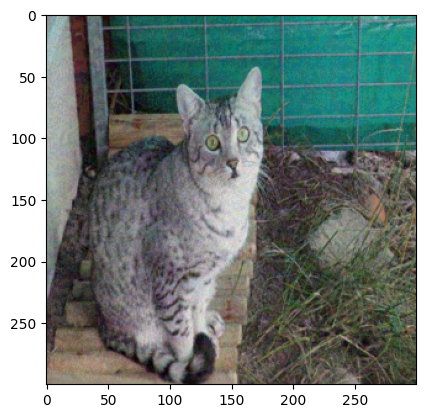

In [108]:
image_path = f'../resources/toy_images/n02124075_14267.png'
img = load_image(image_path)
plt.imshow(img)
plt.show()

In [109]:
img = torch.tensor(np.expand_dims(img, axis=0)).to(device)
img = img.permute(0, 3, 1, 2)
# preds = clf_images_paints(img)

ACTUAL = 1 # cat
TARGET = 3 # attack direction

clf_bp_pred = int(clf_images_paints(img).argmax(1))
print(f'Clf Bp pred: {IMAGENET_7_LABELS[clf_bp_pred]} ({clf_bp_pred})')
print(f'Adversary target: {IMAGENET_7_LABELS[TARGET]} ({TARGET})')

Clf Bp pred: cat (1)
Adversary target: dog (3)


In [110]:
num_classes = len(IMAGENET_7_LABELS.values())
names_classes = list(IMAGENET_7_LABELS.values())
num_paint_steps = 16

#### Load a fully-connected decisioner that was trained using FGSM attacks on PCL model

In [28]:
load_model_path = f'../resources/models/train_decisioner_fc_fgsm/model.pth'
decisioner = DecisionerFC(num_classes, num_paint_steps).to(device)
decisioner = load_model(decisioner, load_model_path, device)
decisioner = decisioner.to(device)
decisioner.eval()
print()

# Try to attack our model

### Load Actor & Renderer (Painter model)

In [31]:
actor_path = f'../resources/models/painter_actor/actor.pkl'
renderer_path = f'../resources/models/painter_renderer/renderer.pkl'
actor = ActorResNet(9, 18, 65) # 65 = 5 (action_bundle) * 13 (stroke parameters)
actor.load_state_dict(torch.load(actor_path))
renderer = RendererFCN()
renderer.load_state_dict(torch.load(renderer_path))

actor = actor.to(device).eval()
renderer = renderer.to(device).eval()
print()

In [35]:
output_every = [50, 100, 200, 300, 400, 500, 600, 700, 950, 1200, 1700, 2200, 3200, 4200, 5200]

In [97]:
start_time = time.time()
canvases = paint_images(img, output_every, device, actor, renderer)
end_time = time.time()
print(f'paint the image took {round(end_time - start_time, 2)} seconds')
print(f'canvas shape: {canvases.shape}')

paint the image took 29.53 seconds
canvas shape: torch.Size([1, 16, 3, 300, 300])


## Attack PCLD Naïvely
## (attack the PCLD model and ignore the painter during backward pass)

In [98]:
# build CLassifier-Decisioner (CLD) model
cld_model = CLD(clf_images_paints, decisioner, num_paint_steps, 'fc')

#### Just a forward pass test: Paint the image then ask CLD to provide a decision

In [114]:
# paint the image
x = paint_images(img, output_every, device, actor, renderer)
cld_model(x)

tensor([[-6.5787, 10.5276, -0.5525,  4.3676, -5.1954, -6.3070,  3.1406]],
       grad_fn=<AddmmBackward0>)

Without introducing any attack, PCLD (correctly) says: cat

#### Failed (Naïve) attack

x_adv shape after canvases attack: torch.Size([1, 16, 3, 300, 300])
avg the resulted attack from 16 to 1 to get the final attack shape same as the input shape (instead of canvases shape)
x_adv shape: torch.Size([1, 3, 300, 300])
classify


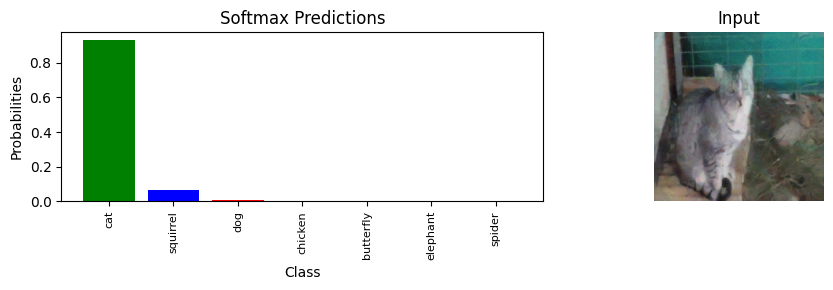

In [115]:
# Attack naively - only the cld model (attack the paint-steps)
epsilon = 48/255
nb_iter = 10
x_adv_paints = projected_gradient_descent(model_fn=cld_model,
                                          x=x,
                                          eps=epsilon,
                                          eps_iter=epsilon/nb_iter,
                                          nb_iter=nb_iter,
                                          norm=np.inf,
                                          y=torch.tensor([TARGET]).to(device),
                                          targeted=True,
                                          rand_init=False,
                                          sanity_checks=False,
                                          clip_min=0, clip_max=1)
print(f'x_adv shape after canvases attack: {x_adv_paints.shape}')
print(f'avg the resulted attack from 16 to 1 to get the final attack shape same as the input shape (instead of canvases shape)')
x_adv = x_adv_paints.mean(dim=1)
print(f'x_adv shape: {x_adv.shape}')
print(f'classify')
x_adv_painted = paint_images(x_adv.detach(), output_every, device, actor, renderer)
output = cld_model(x_adv_painted)
probs = torch.softmax(output, dim=1)
classify(x_adv[0].detach(), probs, ACTUAL, TARGET)
print('=================')

## Attack Adaptively (BPDA)
## (attack PCLD model and use the painter's surrogates during backward pass)

### Load the painter's surrogates

In [112]:
surrogates_folder = f'../resources/models/train_surrogate_painter'
surrogate_list = load_painter_surrogate(surrogates_folder, device, output_every)
# add the image itself (t=∞)
surrogate_list.append(IdentitySurrogate_().to(device))
[s.eval() for s in surrogate_list]
painter_surrogate = PainterSurrogate(surrogate_list)

# initialize models
bpda_painter = BPDAPainter(paint_images, painter_surrogate, output_every, device, actor, renderer)
bpda_painter = bpda_painter.to(device)
bpda_painter.eval()

pcld_adversary = PCLD(bpda_painter, clf_images_paints, decisioner, num_paint_steps, 'fc').to(device).eval()

print()

#### Failed (Adaptive) attack

x_adv_adaptive shape: torch.Size([1, 3, 300, 300])
classify


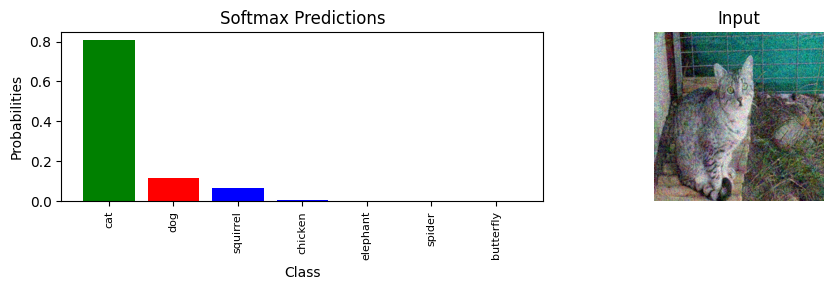

In [113]:
x_adv_adaptive = projected_gradient_descent(model_fn=pcld_adversary,
                                            x=img,
                                            eps=epsilon,
                                            eps_iter=epsilon/nb_iter,
                                            nb_iter=nb_iter,
                                            norm=np.inf,
                                            y=torch.tensor([TARGET]).to(device),
                                            targeted=True,
                                            rand_init=False,
                                            sanity_checks=False,
                                            clip_min=0, clip_max=1)
print(f'x_adv_adaptive shape: {x_adv_adaptive.shape}')
print(f'classify')
output = pcld_adversary(x_adv_adaptive)
probs = torch.softmax(output, dim=1)
classify(x_adv_adaptive[0].detach(), probs, ACTUAL, TARGET)
print('=================')

## Attack the undefended classifier

x_adv_clf shape: torch.Size([1, 3, 300, 300])
classify


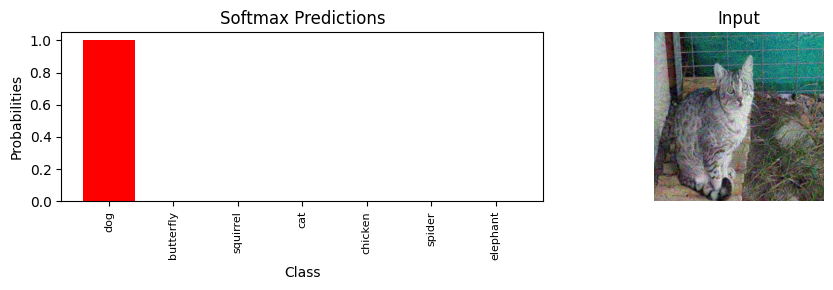

In [117]:
x_adv_clf = projected_gradient_descent(model_fn=clf_images_paints,
                                       x=img,
                                       eps=epsilon,
                                       eps_iter=epsilon/nb_iter,
                                       nb_iter=nb_iter,
                                       norm=np.inf,
                                       y=torch.tensor([TARGET]).to(device),
                                       targeted=True,
                                       rand_init=False,
                                       sanity_checks=False,
                                       clip_min=0, clip_max=1)
print(f'x_adv_clf shape: {x_adv_clf.shape}')
print(f'classify')
output = clf_images_paints(x_adv_clf)
probs = torch.softmax(output, dim=1)
classify(x_adv_clf[0].detach(), probs, ACTUAL, TARGET)
print('=================')